<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumCountriesClassifier_03_Naive_Bayes_ComplementNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [ ]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [ ]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [8]:
def get_num_countries(x):
  if x is not None and type(x) is str:
    return len(x.split(","))
  return None

In [10]:
df_annotations["num_countries"] = df_annotations.country.apply(get_num_countries)

In [11]:
df_annotations["num_countries"].value_counts()

1.0     7998
2.0      726
3.0      341
4.0      263
5.0      230
6.0      225
7.0      193
8.0      176
10.0     155
9.0      137
11.0     135
12.0     116
13.0     109
14.0      92
15.0      90
17.0      78
18.0      68
16.0      65
21.0      57
20.0      56
19.0      54
23.0      47
22.0      44
24.0      35
25.0      31
26.0      27
29.0      22
30.0      21
27.0      20
31.0      19
28.0      18
32.0      17
33.0      14
41.0      11
34.0      11
38.0       8
39.0       8
37.0       7
43.0       7
36.0       6
35.0       6
44.0       6
40.0       6
48.0       6
47.0       3
42.0       2
49.0       2
50.0       2
45.0       1
58.0       1
46.0       1
62.0       1
51.0       1
54.0       1
Name: num_countries, dtype: int64

In [12]:
def get_num_countries_clean(num):
    if num is None or pd.isna(num):
      return None
    if num >= 10:
      return 10
    return num
df_annotations["num_countries_clean"] = df_annotations["num_countries"].apply(get_num_countries_clean)

# Train and evaluate the number of countries extractor

In [13]:
df_train = df_annotations[(df_annotations.train_val == "train") & (~df_annotations.num_countries_clean.isna())]

In [14]:
df_val = df_annotations[df_annotations.train_val == "val"]

In [36]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline

In [37]:
NUM_FEATURES = 1500

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, stop_words=stops, min_df=5, max_features=NUM_FEATURES,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = ComplementNB()
model = make_pipeline(vectoriser, transformer, nb)

In [38]:
model.fit(df_train.text, df_train.num_countries_clean)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['taient', 'tais', 'tait', 'tant', 'tante', 'tantes', 'tants', 'tiez', 'tions'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, min_df=5,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'au',
                                             'aura', 'aurai', 'auraient',
                                             'aurais', 'aurait', 'auras',
                                             'aurez', 'auriez', ...},
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('complementnb', ComplementNB())])

In [39]:
df_val["pred_num_countries"] = model.predict(df_val.text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
pred_num_countries = df_val["pred_num_countries"]

In [41]:
num_countries_ground_truths = df_val.num_countries_clean

In [42]:
acc = accuracy_score(num_countries_ground_truths.apply(str), pred_num_countries.apply(str))
print (f"Num countries accuracy {acc}")

Num countries accuracy 0.6027649769585254


''

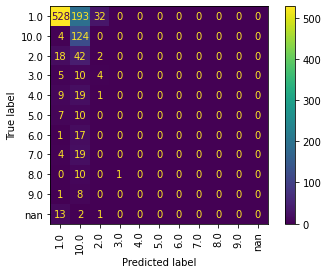

In [43]:
ConfusionMatrixDisplay.from_predictions(num_countries_ground_truths.apply(str), pred_num_countries.apply(str))
plt.xticks(rotation=90)
;

In [44]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(5):
    print(f"Strongest predictors for class {prediction_idx}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")

Streaming output truncated to the last 5000 lines.
1006	post
1007	expected
1008	forms
1009	sensitivity
1010	persistent
1011	containing
1012	injections
1013	database
1014	medication
1015	designed
1016	rash
1017	diseases
1018	diagnostic
1019	form
1020	incidence
1021	state
1022	back
1023	achieve
1024	line
1025	reaction
1026	outside
1027	potential
1028	right
1029	important
1030	distribution
1031	normal
1032	ml
1033	institutional
1034	recurrence
1035	twice
1036	second
1037	published
1038	reviewed
1039	previously
1040	known
1041	direct
1042	size
1043	home
1044	agents
1045	interaction
1046	50%
1047	resolution
1048	investigation
1049	whether
1050	randomized
1051	renal
1052	weekly
1053	established
1054	ef
1055	nts
1056	identified
1057	adverse
1058	scans
1059	activity
1060	ra
1061	developed
1062	hr
1063	might
1064	unable
1065	current
1066	needed
1067	index
1068	imaging
1069	different
1070	both
1071	monitoring
1072	procedure
1073	maintained
1074	therefore
1075	specimens
1076	single
1077	board
107